In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_PATH = "drive/MyDrive/Data" # "Data"

# **Load data**

In [ ]:
def load_data(dataset_folder: str = "Data", subfolder: str = "train"):
    """
    Loads data into a dataframe

    Args:
        dataset_folder (str): Path to the folder containing the data.
                            Default is set to "Data"
        subfolder (str): Specifies the subset of data to load (e.g., 'train', 'test',
                    'dev). Default is set to "train"

    Returns:
        pd.DataFrame: DataFrame containing the combined data from all matching CSV files.
    """
    data = []

    for f in os.listdir(os.path.join(dataset_folder, subfolder)):
        df = pd.read_csv(os.path.join(dataset_folder, subfolder, f))
        data.append(df)

    return pd.concat(data)

In [ ]:
df_train = load_data(DATASET_PATH, "train")
df_dev = load_data(DATASET_PATH, "dev")
df_test = load_data(DATASET_PATH, "test")

In [ ]:
df_full = pd.concat([df_train, df_dev, df_test])

# **Data Analysis**

In [ ]:
total_nb_of_samples = len(df_full)
print("Number of samples in total : ", total_nb_of_samples)
print("--- Percentage of the data ---")
for split, df in zip(["Train", "Dev", "Test"], [df_train, df_dev, df_test]):
    print(f"{split} : {len(df) / total_nb_of_samples * 100: .1f} %")

Number of samples in total :  1339083
--- Percentage of the data ---
Train :  81.2 %
Dev :  9.4 %
Test :  9.4 %


## a) Analysis of the labels

#### Check whether there exist some family_accession that are not in df_train

In [ ]:
assert len(df_full["family_accession"].unique()) == len(df_train["family_accession"].unique()), "Some family_accession are missing in 'train'"
print("OK - No family_accession is missing in 'train'")

OK - No family_accession is missing in 'train'


#### Check whether each family_id is associated with a unique family_accession, and vice versa

In [ ]:
assert df_full.groupby("family_id")["family_accession"].nunique().max() == 1, "There exists a family id that has multiple family_accession"
assert df_full.groupby("family_accession")["family_id"].nunique().max() == 1, "There exists a family_accession that has multiple family_id"
print("OK - Each family_id is associated with a unique family_accession, and vice versa")

OK - Each family_id is associated with a unique family_accession, and vice versa


#### Checking whether a same family_accession has different versions (PFxxxxx.y, i.e there exists a same xxxxxx that has different y)

In [ ]:
def get_accession_number(s):
    return str(s.split('.')[0][2:])

def get_version(s):
    return str(s.split('.')[1])

df_full["accession_number"] = df_full["family_accession"].apply(get_accession_number)
df_full["version"] = df_full["family_accession"].apply(get_version)

assert df_full.groupby("accession_number")["version"].nunique().max() == 1, "There exists an accession_number that has different versions"
print("OK - Each accession number is associated to a unique version")

OK - Each accession number is associated to a unique version


#### Conclusion : We can use either family_id or family_accession for the labels, it is the same

### Analysis of the labels distribution

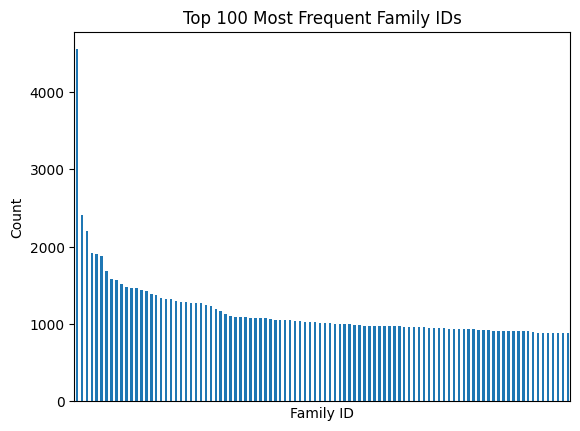

In [ ]:
nb_families_to_plot = 100

family_id_counts = df_full['family_id'].value_counts()
top_family_id_counts = family_id_counts.head(nb_families_to_plot)

top_family_id_counts.plot(kind='bar')
plt.title(f'Top {nb_families_to_plot} Most Frequent Family IDs')
plt.xlabel('Family ID')
plt.ylabel('Count')
plt.xticks([])
plt.show()

In [ ]:
family_id_counts.describe()

count    17929.000000
mean        74.688103
std        144.505273
min          1.000000
25%          9.000000
50%         26.000000
75%         80.000000
max       4545.000000
Name: family_id, dtype: float64

Conclusion : the dataset is unbalanced.
For the beginning, I will only keep the top 100 classes. I will see later how to deal with all the classes.

## b) Analysis of the sequences

#### Analysis of the length of the sequences

(0.0, 800.0)

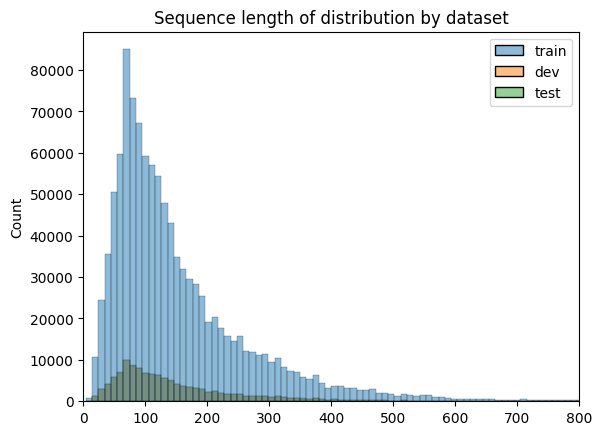

In [ ]:
all_sequence_lengths = []
split_types = []
for split, df in zip(["train", "dev", "test"], [df_train, df_dev, df_test]):
    sequences_lengths = df['sequence'].apply(len).to_list()
    nb_sequences = len(sequences_lengths)
    all_sequence_lengths += sequences_lengths
    split_types += (nb_sequences * [split])

sns.histplot(x=all_sequence_lengths, hue=split_types, bins=200)
plt.title("Sequence length of distribution by dataset")
plt.xlim((0,800))

In [ ]:
df_full["sequence"].apply(len).describe()

count    1.339083e+06
mean     1.551566e+02
std      1.197877e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: sequence, dtype: float64

Based on these observations, we will truncate the sequences to some value between 200 and 600 (this will be a hyperparameter)

#### Qualitative analysis of the sequences of the same family

In [ ]:
family_id = "LRR_1"
small_df = df_full[df_full["family_id"] == family_id].reset_index(drop=True)
small_df.head(2)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,accession_number,version
0,LRR_1,FMOD_BOVIN/130-154,PF00560.33,GLLWI....A......L...........HGNQ.....IT..........,GLLWIALHGNQITSDKVGKKVFSKL,00560,33
1,LRR_1,Q9EME3_AMEPV/190-210,PF00560.33,NLKNL....I......F...........HKTN.....I...........,NLKNLIFHKTNINSLLDIYNL,00560,33


In [ ]:
text = ""
for index, row in small_df[:5].iterrows():
    new_text = f"""--- Protein n° {index+1} ---\nSequence : {row["sequence"]}\nAligned sequence : {row["aligned_sequence"]}\n\n"""
    text = text + new_text

print(text)

--- Protein n° 1 ---
Sequence : GLLWIALHGNQITSDKVGKKVFSKL
Aligned sequence : GLLWI....A......L...........HGNQ.....IT...............SDKVGKKV...FS..........K.L

--- Protein n° 2 ---
Sequence : NLKNLIFHKTNINSLLDIYNL
Aligned sequence : NLKNL....I......F...........HKTN.....I.................N..SLLD...IY..........N.L

--- Protein n° 3 ---
Sequence : SLLRLSLYNNCICDVGAESLARV
Aligned sequence : SLLRL....S......L...........YNNC.....I.................CDVGAES...LA..........R.V

--- Protein n° 4 ---
Sequence : RLKYLSICNTGIHKLPDVTKIF
Aligned sequence : RLKYL....S......I...........CNTG.....I..................HKLPDV...TK..........I.F

--- Protein n° 5 ---
Sequence : GLRYLILECPQITQIPDSLGNL
Aligned sequence : GLRYL...........I...........LECP.....Q.................ITQIPDS...LG..........N.L




## c) Analysis of the frequency of all the amino acids

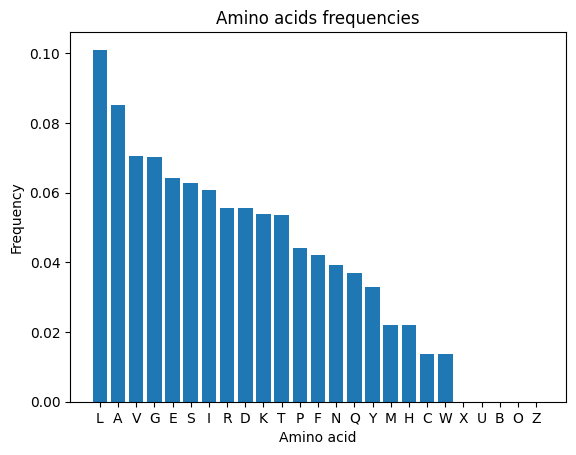

In [ ]:
counter = Counter()
df_full['sequence'].apply(lambda seq: counter.update(list(seq)))

amino_acids_counts = list(counter.items())
amino_acids_counts.sort(key=lambda x: x[1], reverse=True)

amino_acids_names, amino_acids_frequencies = [], []
for aa, count in amino_acids_counts:
    amino_acids_names.append(aa)
    amino_acids_frequencies.append(count)

amino_acids_frequencies /= np.sum(amino_acids_frequencies)

plt.bar(amino_acids_names, amino_acids_frequencies)
plt.title(f'Amino acids frequencies')
plt.xlabel('Amino acid')
plt.ylabel('Frequency')
plt.show()

In [ ]:
amino_acids_to_keep = amino_acids_names[:-5]
amino_acids_to_delete = amino_acids_names[-5:]
print(f"Amino acids to keep : {amino_acids_to_keep}\nAmino acids to delete : {amino_acids_to_delete}")

Amino acids to keep : ['L', 'A', 'V', 'G', 'E', 'S', 'I', 'R', 'D', 'K', 'T', 'P', 'F', 'N', 'Q', 'Y', 'M', 'H', 'C', 'W']
Amino acids to delete : ['X', 'U', 'B', 'O', 'Z']


# **Data Processing**

## Amino acids that we consider

In [ ]:
amino_acids_to_keep = list("ACDEFGHIKLMNPQRSTVWY")
dict_amino_acid_to_int = {aa: idx+1 for idx, aa in enumerate(amino_acids_to_keep)}

## Preprocess functions

In [ ]:
def encode_amino_acid_sequence(sequence, dict_amino_acid_to_int):
    """
    Given a list of amino acids, it encodes every amino acid

    Args:
        s (str) : string of a protein
    """

    l = []
    for aa in sequence:
        # Try whether the amino acid is in dicitonary
        try:
            l.append(dict_amino_acid_to_int[aa])
        except KeyError:
            pass
    return l


def pad_amino_acid_sequence(sequence, sequences_length, padding='post'):
    padded_sequence = tf.keras.utils.pad_sequences([sequence],
                                                    maxlen=sequences_length,
                                                    padding=padding)[0]
    return padded_sequence


def preprocess_data(df, label_encoder, classes_to_keep, sequences_length, dict_amino_acid_to_int, padding='post'):
    # Remove some classes
    mask_classes_to_keep = df['family_accession'].isin(classes_to_keep)
    df = df.loc[mask_classes_to_keep, :].reset_index(drop=True)

    # Transform amino acids sequences into list of integers
    df['sequence_encoded'] = df['sequence'].apply(lambda seq: encode_amino_acid_sequence(seq, dict_amino_acid_to_int))
    df['sequence_encoded'] = df['sequence_encoded'].apply(lambda seq: pad_amino_acid_sequence(seq, sequences_length, padding=padding))

    # Encode labels
    df["label"] = label_encoder.transform(df["family_accession"])

    # Shuffle
    df.sample(frac=1).reset_index(drop=True)

    # Return X and y
    X = np.array(df["sequence_encoded"].tolist())
    y = df["label"].to_numpy()

    return X, y

## Preprocessing parameters


In [ ]:
sequences_length = 300
num_classes = 100
padding = 'post'

## Preprocessing

In [ ]:
# Compute label encoder for all the classes
classes_counts = df_train['family_accession'].value_counts()
classes_to_keep = list(classes_counts.index[:num_classes])
label_encoder = sklearn.preprocessing.LabelEncoder().fit(classes_to_keep)

# Preprocess the data
X_train, y_train = preprocess_data(df_train, label_encoder, classes_to_keep, sequences_length, dict_amino_acid_to_int, padding=padding)
X_dev, y_dev = preprocess_data(df_dev, label_encoder, classes_to_keep, sequences_length, dict_amino_acid_to_int, padding=padding)
X_test, y_test = preprocess_data(df_test, label_encoder, classes_to_keep, sequences_length, dict_amino_acid_to_int, padding=padding)

# Convert to categorical for training
y_train_categorical = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_dev_categorical = keras.utils.to_categorical(y_dev, num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes=num_classes)

## Classes weights

In [ ]:
class_weights_train = sklearn.utils.class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_train_dict = dict(enumerate(class_weights_train))

# Model

## Data parameters

In [ ]:
data_params = {
    'input_dim': len(amino_acids_to_keep) + 1,
    'input_length': sequences_length,
    'num_classes': num_classes
}

## Helper fuctions

In [ ]:
def _test_model(class_model, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32):
    model = class_model(**data_params, **embedding_params, **model_params)

    input = tf.keras.Input(input_shape, batch_size=batch_size)
    output = model(input)

    expected_output_shape_with_batch = (batch_size,) + expected_output_shape

    assert output.shape == expected_output_shape_with_batch, f"Output should be {expected_output_shape_with_batch}, but it is {output.shape}"
    print("Test passed")

In [ ]:
def compile_and_train_model(model, X, y_categorical, learning_rate, epochs, batch_size, validation_split, class_weight, early_stopping_patience, **kwargs):
    # Pour windows Adam : tf.keras.optimizers.Adam(learning_rate)
    # Pour mac M1/M2 : tf.keras.optimizers.legacy.Adam(learning_rate)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) # sparse_categorical_crossentropy

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   min_delta=0,
                                                   patience=early_stopping_patience,
                                                   verbose=0,
                                                   mode='auto')

    history = model.fit(X,
                        y_categorical,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        class_weight=class_weight,
                        callbacks=[early_stopping])

    return history

In [ ]:
def show_history(history):
    """
    Show the loss and the accuracy
    """
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(epochs, train_loss, label='Training loss')
    ax[0].plot(epochs, val_loss, label='Validation loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_accuracy, label='Training accuracy')
    ax[1].plot(epochs, val_accuracy, label='Validation accuracy')
    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_protein_embeddings(model, X, y, nb_classes_to_analyze=30, nb_proteins_per_class=30, batch_size=32):
    # Compute top classes
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    sorted_classes = unique_classes[np.argsort(class_counts)[::-1]]
    top_classes = sorted_classes[:nb_classes_to_analyze]

    # Filter data
    # Filter data
    filtered_indices = []
    for class_label in top_classes:
        indices_for_class = np.where(y == class_label)[0]
        if len(indices_for_class) > nb_proteins_per_class:
            indices_for_class = indices_for_class[:nb_proteins_per_class]
        filtered_indices.extend(indices_for_class)

    X = X[filtered_indices]
    y = y[filtered_indices]

    # Compute embeddings
    embeddings_list = []

    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size]
        batch_embeddings = model.get_embedding_before_classification(batch_X)
        embeddings_list.append(batch_embeddings)

    embeddings = np.concatenate(embeddings_list, axis=0)

    # Visualize
    tsne = TSNE(n_components=2)
    embeddings_tsne = tsne.fit_transform(embeddings)

    class_colors = {}
    for label in top_classes:
        class_colors[label] = np.random.rand(3,)

    plt.figure(figsize=(8, 8))
    plt.title("Embeddings of the amino acids")
    for i, (coord_x, coord_y) in enumerate(embeddings_tsne):
        label = y[i]
        color = class_colors[label]
        plt.scatter(coord_x, coord_y, color=color)

    plt.legend()
    plt.show()

## A simple model

### Model creation

In [ ]:
class EmbeddingLayer(tf.keras.Model):
    def __init__(self, input_dim, embedding_output_dim, input_length, embedding_by_position=False, **kwargs):
        super().__init__()
        self.amino_acid_embedding = layers.Embedding(input_dim=input_dim, output_dim=embedding_output_dim, input_length=input_length)

        self.embedding_by_position = embedding_by_position
        if self.embedding_by_position:
            self.position_embedding = layers.Embedding(input_dim=input_length, output_dim=embedding_output_dim)
            self.sequences_length = sequences_length

    def call(self, inputs, training=False):
        x = self.amino_acid_embedding(inputs)

        if self.embedding_by_position:
            x += self.position_embedding(tf.range(self.sequences_length))
        return x


def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True
    }
    model_params = {}

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])

    _test_model(EmbeddingLayer, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)


_test()

Test passed


In [ ]:
class SimpleModel(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, nb_dense_units=128, dropout_rate=0.2, embedding_by_position=False, **kwargs):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                             embedding_output_dim=embedding_output_dim,
                                             input_length=input_length,
                                             embedding_by_position=embedding_by_position)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')

        self.activations = {}

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.flatten(x)
        self.activations['embedding'] = x

        x = self.dense(x)
        self.activations['dense'] = x

        x = self.dropout(x, training=training)

        x = self.dense_softmax(x)
        self.activations['softmax'] = x

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training=training)

        return x


def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True
    }
    model_params = {
        'nb_dense_units': 256,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(SimpleModel, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)


_test()

Test passed


### Hyperparameters

In [ ]:
embedding_params = {
    'embedding_output_dim': 10,
    'embedding_by_position': False
}
model_params = {
    'nb_dense_units': 256,
    'dropout_rate': 0.2
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'validation_split': 0.1,
    'early_stopping_patience': 5,
    'class_weight': class_weights_train_dict
}

### Train

In [ ]:
model = SimpleModel(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
1308/1308 [==============================] - 12s 7ms/step - loss: 0.4385 - accuracy: 0.9013 - val_loss: 0.0366 - val_accuracy: 0.9915
Epoch 2/50
1308/1308 [==============================] - 9s 7ms/step - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.0239 - val_accuracy: 0.9940
Epoch 3/50
1308/1308 [==============================] - 6s 4ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0217 - val_accuracy: 0.9943
Epoch 4/50
1308/1308 [==============================] - 8s 6ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0246 - val_accuracy: 0.9941
Epoch 5/50
1308/1308 [==============================] - 6s 5ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0244 - val_accuracy: 0.9941
Epoch 6/50
1308/1308 [==============================] - 11s 9ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0314 - val_accuracy: 0.9924
Epoch 7/50
1308/1308 [==============================] - 6s 5ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0313 - val_accurac

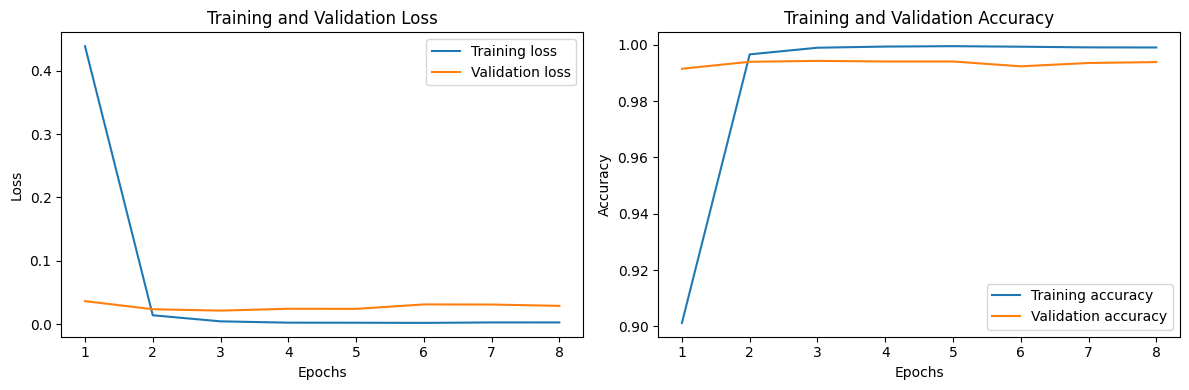

In [ ]:
show_history(history)

### Tests

In [ ]:
model.evaluate(X_dev, y_dev_categorical)

362/362 [==============================] - 1s 3ms/step - loss: 0.0310 - accuracy: 0.9937


[0.030971594154834747, 0.9936878681182861]

### Analysis of the model

#### The amino acids embeddings

In [ ]:
# Encode amino acids
amino_acids_encoded = encode_amino_acid_sequence(amino_acids_to_keep, dict_amino_acid_to_int)
amino_acids_encoded_padded = pad_amino_acid_sequence(amino_acids_encoded, sequences_length=sequences_length, padding=padding)

# Compute embeddings
output = model.embedding_layer(np.array([amino_acids_encoded_padded]))
embeddings = output[0, 0:len(amino_acids_to_keep), :]

##### Principal Component Analysis (PCA)

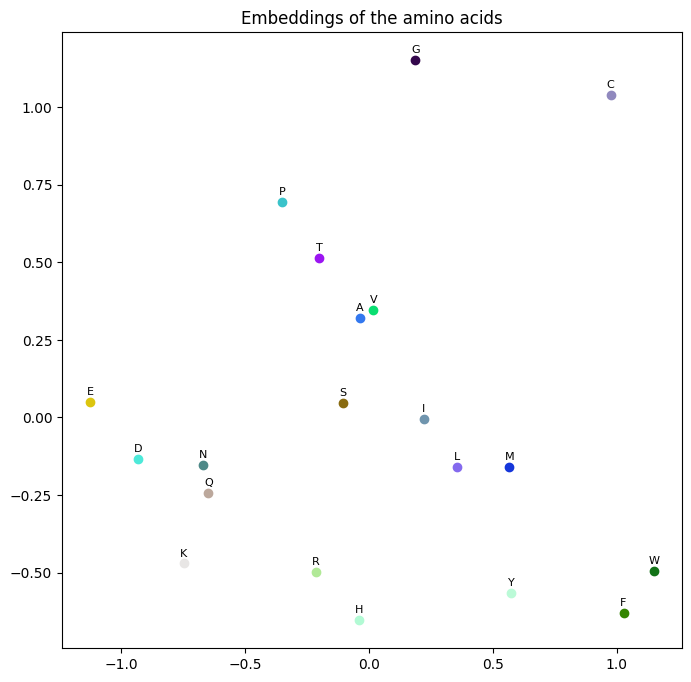

In [ ]:
# Compute PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Show
plt.figure(figsize=(8, 8))
plt.title("Embeddings of the amino acids")
for i, (x, y) in enumerate(embeddings_pca):
    plt.scatter(x, y, color=np.random.rand(3,))
    plt.annotate(amino_acids_to_keep[i], (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.show()

We notice that amino acids that share some properties are close to each other. For instance :
- Leucine and Isoleucine are close to each other
- Aromatic amino acids (Tryptophan, Tyrosin, Phenylalanin) are close to each other
- Acid aspartic and acid glutamic

It seems that the model captured some properties of amino acids.

##### Similarity between amino acids

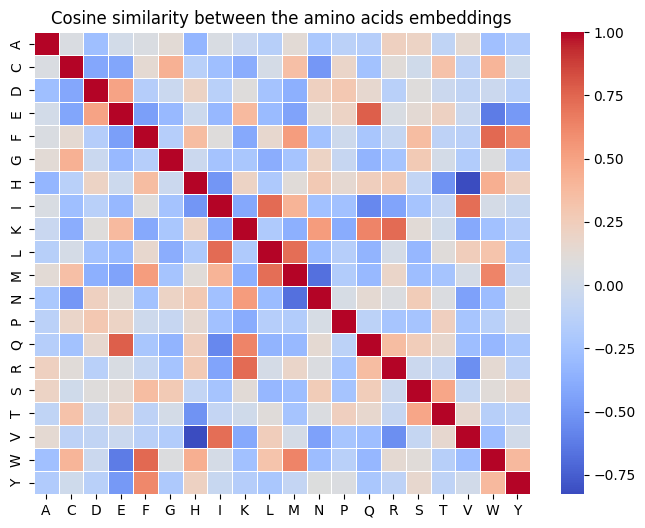

In [ ]:
# Compute similarities
similarities = sklearn.metrics.pairwise.cosine_similarity(embeddings)

# Show heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarities, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5,
            xticklabels=amino_acids_to_keep, yticklabels=amino_acids_to_keep)  # Utilisation des labels pour les axes
plt.title('Cosine similarity between the amino acids embeddings')
plt.show()

This confirms what the previous figure shows.

#### The protein embeddings

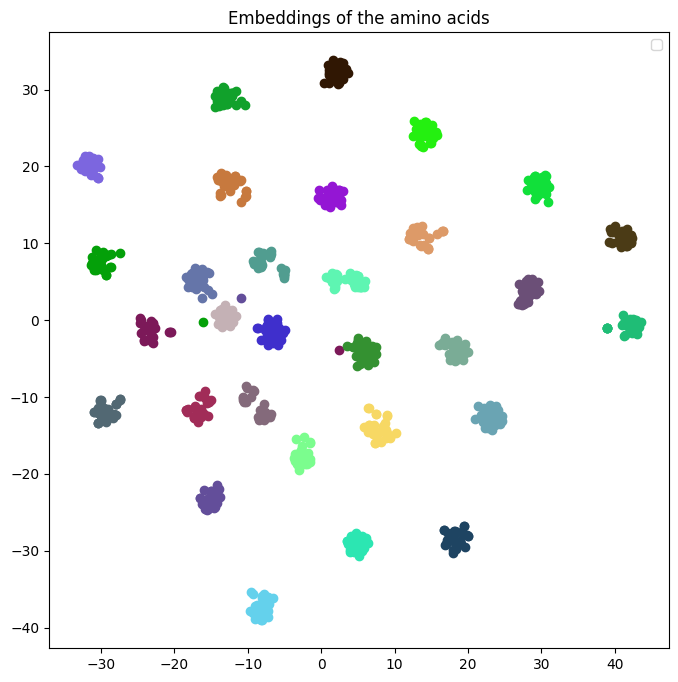

In [ ]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

The model has been able to make a great separation between all the protein domains.

#### Visualization of the neurons activation

In [ ]:
# Parameters
nb_classes_to_compare = 5
nb_proteins_to_keep_per_class = 20

# Compute the labels to compare
unique_labels = np.unique(y_train)
labels_to_compare = unique_labels[:nb_classes_to_compare]

In [ ]:
# Initialize list that will contain the activations
all_X = []
all_activations = {'embedding': [], 'dense': [], 'softmax': []}

# Get all the activation values
for label in labels_to_compare:
    X = X_train[y_train == label][:nb_proteins_to_keep_per_class]
    all_X.append(X)
    _ = model(X)

    for key, value in model.activations.items():
        all_activations[key].append(value[:, :150]) # We only keep the 150 first values of every layer, in order to be able to see something

# Convert to numpy
all_X = np.concatenate(all_X, axis=0)
for key, value in all_activations.items():
    all_activations[key] = np.concatenate(value, axis=0)

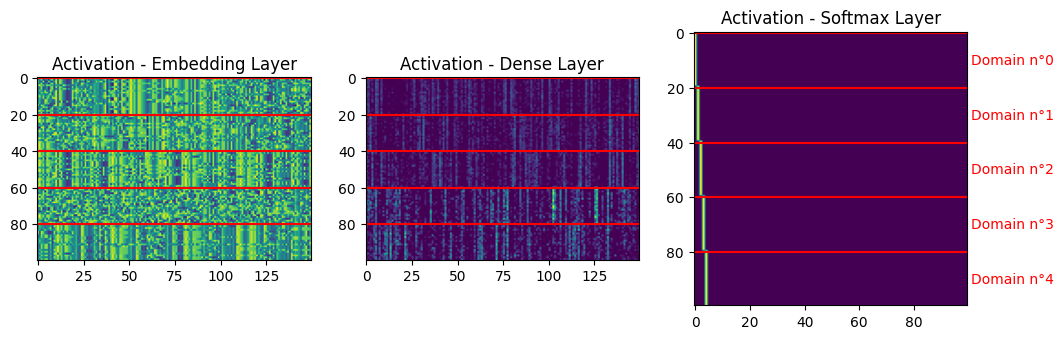

In [ ]:
# Show
plt.figure(figsize=(12, 12))

cmap = 'viridis'
for subplot, layer in zip([131, 132, 133], ['embedding', 'dense', 'softmax']):
    plt.subplot(subplot)
    plt.imshow(all_activations[layer], cmap=cmap)
    plt.title(f'Activation - {layer.capitalize()} Layer')
    for i in range(nb_classes_to_compare):
        plt.axhline(y=i*nb_proteins_to_keep_per_class, color='red')

        if subplot == 133:
            plt.text(x=all_activations[layer].shape[-1] + 1,
                     y=(i + 1/2)*nb_proteins_to_keep_per_class,
                     s=f'Domain n°{i}',
                     color='red',
                     va='center')

plt.show()

For multiple sequences from a same family, we can see that there are some common areas in the first embedding.
It shows that the model was able to find some patterns in the amino acid sequences.
We can also see that the neurons that activate in the dense layer are (almost) always the same for a same family.

## Convolutional Neural Network

### Model creation

In [ ]:
class CNN(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, nb_filters_per_kernel_size=16, kernel_sizes=[7, 11, 15, 17, 19, 21, 23, 25], nb_dense_units=256, dropout_rate=0.2, embedding_by_position=False, **kwargs):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position)
        self.flatten = layers.Flatten()

        self.convs = [layers.Conv1D(filters=nb_filters_per_kernel_size, kernel_size=kernel_size, activation='relu', padding='same') for kernel_size in kernel_sizes]
        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training)
        x = self.dense_softmax(x)
        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training)
        return x

def _test():
    embedding_params = {
        'embedding_output_dim': 20,
        'embedding_by_position': True
    }
    model_params = {
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [3, 7],
        'nb_dense_units': 256,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(CNN, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)

_test()

Test passed


### Hyperparameters

In [ ]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}
model_params = {
    'nb_filters_per_kernel_size': 16,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 256,
    'dropout_rate': 0.3
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'validation_split': 0.1,
    'early_stopping_patience': 5,
    'class_weight': class_weights_train_dict
}

### Train

In [ ]:
model = CNN(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
1308/1308 [==============================] - 23s 15ms/step - loss: 0.2629 - accuracy: 0.9369 - val_loss: 0.0195 - val_accuracy: 0.9949
Epoch 2/50
1308/1308 [==============================] - 16s 12ms/step - loss: 0.0188 - accuracy: 0.9954 - val_loss: 0.0112 - val_accuracy: 0.9973
Epoch 3/50
1308/1308 [==============================] - 17s 13ms/step - loss: 0.0081 - accuracy: 0.9975 - val_loss: 0.0146 - val_accuracy: 0.9967
Epoch 4/50
1308/1308 [==============================] - 16s 12ms/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0141 - val_accuracy: 0.9968
Epoch 5/50
1308/1308 [==============================] - 17s 13ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0150 - val_accuracy: 0.9970
Epoch 6/50
1308/1308 [==============================] - 16s 12ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0157 - val_accuracy: 0.9965
Epoch 7/50
1308/1308 [==============================] - 16s 13ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.0145 -

### Tests

In [ ]:
model.evaluate(X_dev, y_dev_categorical)

362/362 [==============================] - 2s 5ms/step - loss: 0.0121 - accuracy: 0.9971


[0.012130639515817165, 0.9971465468406677]

### Analysis of the model

#### Protein embeddings

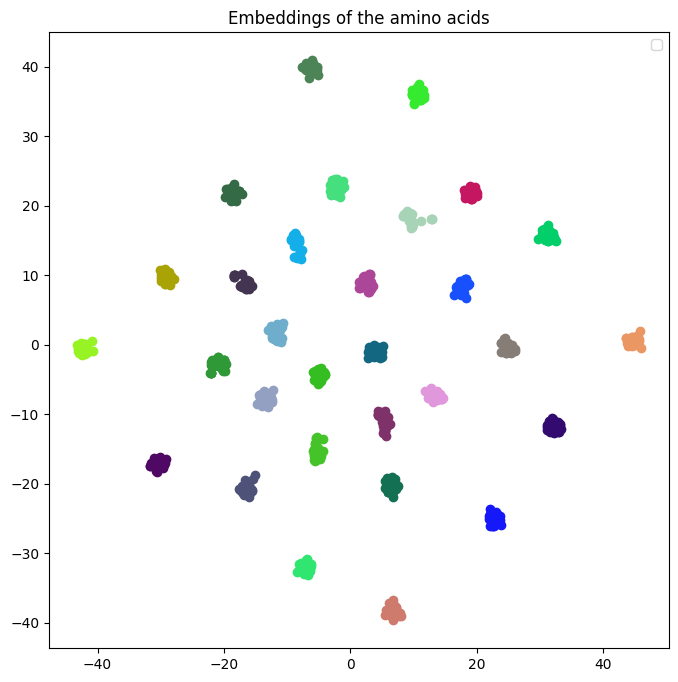

In [ ]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

## Residual neural network

### Model creation

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, layer_index, num_first_dilated_layer=2, dilation_rate=2, bottleneck_factor=0.5, nb_filters_per_kernel_size=100, kernel_sizes=[9, 17], dropout_rate=0.2, **kwargs):
        super().__init__()
        self.layer_index = layer_index

        # Calculate dilation rate for this block
        shifted_layer_index = (layer_index + 1) - num_first_dilated_layer + 1
        self.dilation_rate = max(1, dilation_rate ** shifted_layer_index)

        self.num_bottleneck_units = int(math.floor(bottleneck_factor * nb_filters_per_kernel_size))

        # First Convolution Layer in the Residual Block
        self.conv1 = [tf.keras.layers.Conv1D(
            filters=self.num_bottleneck_units,
            kernel_size=kernel_size,
            padding='same',
            dilation_rate=self.dilation_rate
        ) for kernel_size in kernel_sizes]

        # Second Convolution Layer in the Residual Block
        self.conv2 = tf.keras.layers.Conv1D(
            filters=nb_filters_per_kernel_size*len(kernel_sizes),
            kernel_size=1,  # kernel size of 1 for the linear transformation
            padding='same'
        )

        self.relu = layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        x = inputs
        #x = tf.keras.layers.BatchNormalization()(x)
        x = self.relu(x)
        x = tf.concat([conv(x) for conv in self.conv1], axis=-1)
        x = self.dropout(x, training=training)
        #x = tf.keras.layers.BatchNormalization()(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.dropout(x, training=training)
        x += inputs

        return x

def _test():
    embedding_params = {}
    model_params = {
        'layer_index': 0,
        'num_first_dilated_layer': 2,
        'dilation_rate': 2,
        'bottleneck_factor': 0.5,
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [3, 9],
        'dropout_rate': 0.2
    }

    latent_dim = model_params['nb_filters_per_kernel_size'] * len(model_params['kernel_sizes'])

    input_shape = (data_params['input_length'], latent_dim)
    expected_output_shape = (data_params['input_length'], latent_dim)

    _test_model(ResidualBlock, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)


_test()

Test passed


In [ ]:
class ProteinResNet(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, num_layers=5, num_first_dilated_layer=2, dilation_rate=2, bottleneck_factor=0.5, nb_filters_per_kernel_size=100, kernel_sizes=[9, 17], nb_dense_units=256, dropout_rate=0.2, embedding_by_position=False):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position)

        self.convs = [tf.keras.layers.Conv1D(
            filters=nb_filters_per_kernel_size,
            kernel_size=kernel_size,
            padding='same'
        ) for kernel_size in kernel_sizes]

        self.residual_blocks = [ResidualBlock(layer_index=i,
                                              num_first_dilated_layer=num_first_dilated_layer,
                                              dilation_rate=dilation_rate,
                                              bottleneck_factor=bottleneck_factor,
                                              nb_filters_per_kernel_size=nb_filters_per_kernel_size,
                                              kernel_sizes=kernel_sizes,
                                              dropout_rate=dropout_rate) for i in range(num_layers)]

        self.dense = layers.Dense(nb_dense_units, activation='softmax')
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.dropout(x, training=training)

        for residual_block in self.residual_blocks:
            x = residual_block(x, training)

        x = layers.Flatten()(x) # Better than max pooling
        x = self.dense(x)
        x = self.dropout(x, training=training)

        x = self.dense_softmax(x)

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.dropout(x, training=training)

        for residual_block in self.residual_blocks:
            x = residual_block(x, training)

        x = layers.Flatten()(x) # Better than max pooling
        x = self.dense(x)
        x = self.dropout(x, training=training)

        return x

def _test():
    embedding_params = {
        'embedding_output_dim': 20,
        'embedding_by_position': False
    }
    model_params = {
        'num_layers': 5,
        'num_first_dilated_layer': 2,
        'dilation_rate': 2,
        'bottleneck_factor': 0.5,
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
        'nb_dense_units': 256,
        'dropout_rate': 0.4
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(ProteinResNet, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=8)

_test()

Test passed


### Hyperparameters

In [ ]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}
model_params = {
    'num_layers': 3,
    'num_first_dilated_layer': 2,
    'dilation_rate': 2,
    'bottleneck_factor': 0.5,
    'nb_filters_per_kernel_size': 16,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 128,
    'dropout_rate': 0.4
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 128,
    'epochs': 30,
    'validation_split': 0.1,
    'early_stopping_patience': 5,
    'class_weight': class_weights_train_dict
}

### Train

In [ ]:
model = ProteinResNet(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/30
654/654 [==============================] - 101s 138ms/step - loss: 4.4177 - accuracy: 0.0318 - val_loss: 4.2013 - val_accuracy: 0.0560
Epoch 2/30
654/654 [==============================] - 80s 123ms/step - loss: 4.1934 - accuracy: 0.0368 - val_loss: 3.9756 - val_accuracy: 0.0624
Epoch 3/30
654/654 [==============================] - 78s 119ms/step - loss: 4.4412 - accuracy: 0.0227 - val_loss: 4.5657 - val_accuracy: 0.0155
Epoch 4/30
654/654 [==============================] - 77s 118ms/step - loss: 4.5687 - accuracy: 0.0126 - val_loss: 4.4798 - val_accuracy: 0.0225
Epoch 5/30
654/654 [==============================] - 77s 118ms/step - loss: 4.5101 - accuracy: 0.0143 - val_loss: 4.3367 - val_accuracy: 0.0255
Epoch 6/30
654/654 [==============================] - 81s 124ms/step - loss: 4.3782 - accuracy: 0.0182 - val_loss: 4.2079 - val_accuracy: 0.0291
Epoch 7/30
654/654 [==============================] - 77s 118ms/step - loss: 4.2396 - accuracy: 0.0199 - val_loss: 4.0084 - val_a

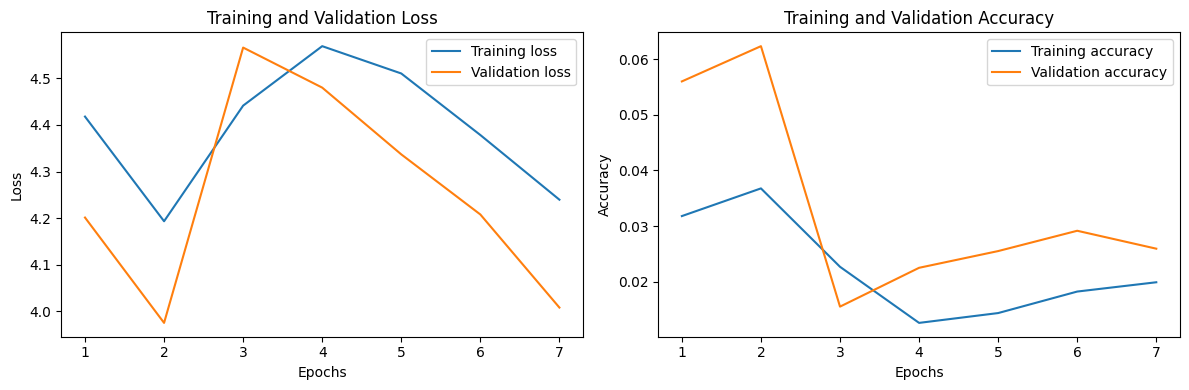

In [ ]:
show_history(history)

### Tests

In [ ]:
model.evaluate(X_dev, y_dev_categorical)

362/362 [==============================] - 10s 20ms/step - loss: 4.0111 - accuracy: 0.0271


[4.011114597320557, 0.02706441842019558]

### Analysis of the model

#### Protein embeddings

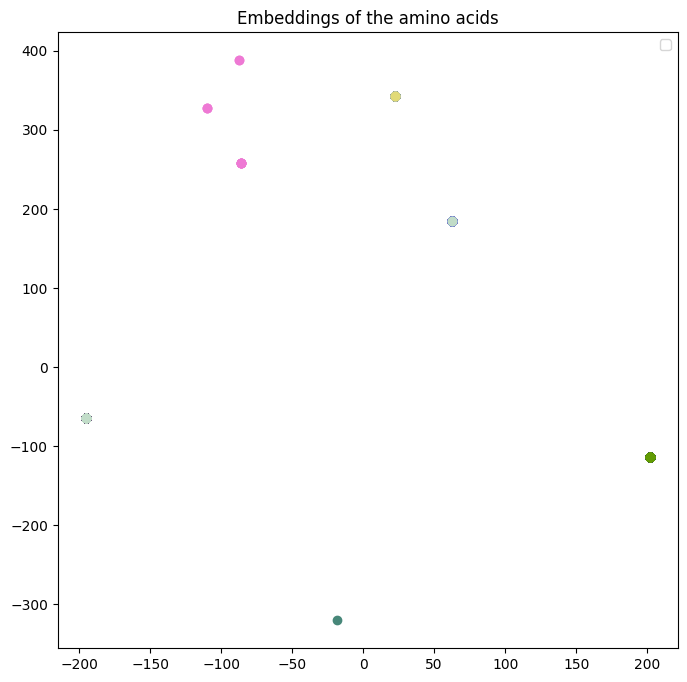

In [ ]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

## Transformer

### Model creation

In [ ]:
class TransformerBlock(tf.keras.Model):
    def __init__(self, num_heads, dim_heads, latent_dim, mlp_dim, dropout_rate=0.1, **kwargs):
        super().__init__()
        self.multi_head_attention_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim_heads)
        self.dense1 = layers.Dense(mlp_dim, activation='gelu')
        self.dense2 = layers.Dense(latent_dim, activation='gelu')
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.dropout = layers.Dropout(dropout_rate)

    def __call__(self, inputs, training=False):
        x = self.layer_norm1(inputs)

        attention_output = self.multi_head_attention_layer(x, x)
        attention_output += x

        y = self.layer_norm2(attention_output)
        y = self.dense1(y)
        y = self.dropout(y, training=training)
        y = self.dense2(y)
        y = self.dropout(y, training=training)

        return y + attention_output

def _test():
    model_params = {
        'latent_dim': 20,
        'num_heads': 8,
        'dim_heads': 16,
        'mlp_dim': 30,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])
    expected_output_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])

    _test_model(TransformerBlock, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)

_test()

Test passed


In [ ]:
class Transformer(tf.keras.Model):
    """
    Il faut que je pense à ajouter l'histoire de pooling à la place du flatten
    """
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, num_layers, num_heads, dim_heads, mlp_dim=128, dropout_rate=0.1, embedding_by_position=True, **kwargs):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position)

        self.encoder_blocks = [TransformerBlock(num_heads=num_heads,
                                                dim_heads=dim_heads,
                                                latent_dim=embedding_output_dim,
                                                mlp_dim=mlp_dim,
                                                dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.dense_softmax = layers.Dense(num_classes, activation='softmax')
        self.dropout = layers.Dropout(dropout_rate)

    def __call__(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)
        for encoder in self.encoder_blocks:
            x = encoder(x, training=training)
        x = layers.Flatten()(x)
        x = self.dense_softmax(x)

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)
        for encoder in self.encoder_blocks:
            x = encoder(x, training=training)
        x = layers.Flatten()(x)

        return x


def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True
    }
    model_params = {
        'num_layers': 4,
        'num_heads': 8,
        'dim_heads': 16,
        'mlp_dim': 30,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(Transformer, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=8)

_test()

Test passed


### Hyperparameters

In [ ]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': True
}
model_params = {
    'num_layers': 2,
    'num_heads': 4,
    'dim_heads': 8,
    'mlp_dim': 32,
    'dropout_rate': 0.4
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 32,
    'epochs': 50,
    'validation_split': 0.1,
    'early_stopping_patience': 5,
    'class_weight': class_weights_train_dict
}

### Train

In [ ]:
model = Transformer(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
2616/2616 [==============================] - 66s 24ms/step - loss: 2.8844 - accuracy: 0.1394 - val_loss: 3.4987 - val_accuracy: 0.1245
Epoch 2/50
2616/2616 [==============================] - 66s 25ms/step - loss: 1.7681 - accuracy: 0.4068 - val_loss: 2.3469 - val_accuracy: 0.3585
Epoch 3/50
2616/2616 [==============================] - 62s 24ms/step - loss: 1.2773 - accuracy: 0.5757 - val_loss: 1.9447 - val_accuracy: 0.4596
Epoch 4/50
2616/2616 [==============================] - 64s 25ms/step - loss: 1.0628 - accuracy: 0.6539 - val_loss: 1.6421 - val_accuracy: 0.5419
Epoch 5/50
2616/2616 [==============================] - 61s 23ms/step - loss: 0.9064 - accuracy: 0.7121 - val_loss: 1.3805 - val_accuracy: 0.6148
Epoch 6/50
2616/2616 [==============================] - 63s 24ms/step - loss: 0.7970 - accuracy: 0.7485 - val_loss: 1.0643 - val_accuracy: 0.6927
Epoch 7/50
2616/2616 [==============================] - 61s 23ms/step - loss: 0.7163 - accuracy: 0.7741 - val_loss: 1.0434 -

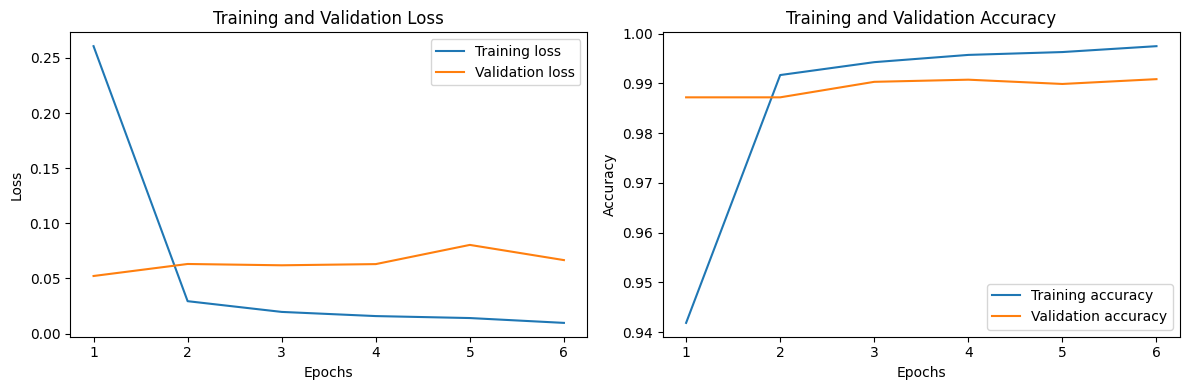

In [ ]:
show_history(history)

### Tests

In [ ]:
model.evaluate(X_dev, y_dev_categorical)

362/362 [==============================] - 6s 16ms/step - loss: 0.0645 - accuracy: 0.9914


[0.06445731222629547, 0.991439700126648]

### Analysis of the model

#### Protein embeddings

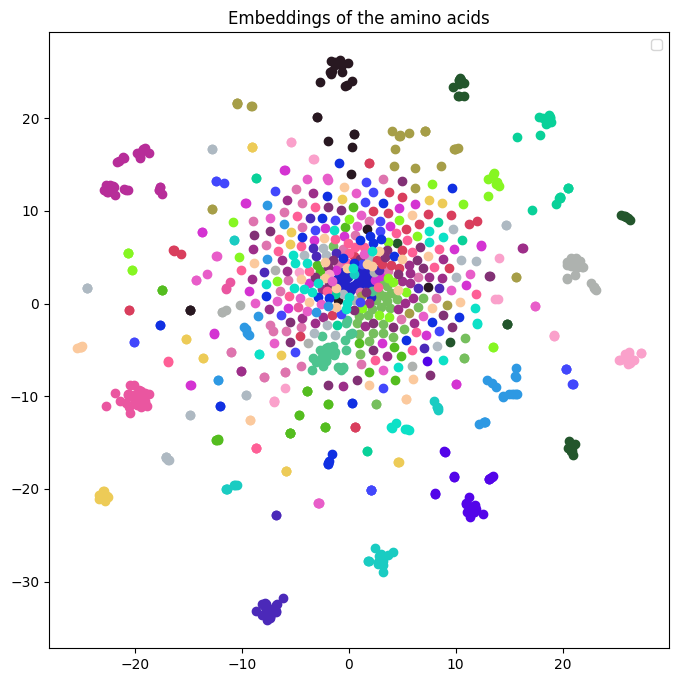

In [ ]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

# Ensemble method

In [ ]:
class EnsembleClassifier:
    def __init__(self, base_model, num_models, *args, **kwargs):
        self.models = []
        self.base_model = base_model
        self.args = args
        self.kwargs = kwargs

        for _ in range(num_models):
            model = self.base_model(*self.args, **self.kwargs)
            self.models.append(model)

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        for model in self.models:
            model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)

    def fit(self, X, y_categorical, epochs, batch_size, validation_split, class_weight, early_stopping_patience):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       min_delta=0,
                                                       patience=early_stopping_patience,
                                                       verbose=0,
                                                       mode='auto')

        for i, model in enumerate(self.models):
            print(f"Training model {i+1}/{len(self.models)}...")
            indices = np.random.choice(len(X), size=len(X))
            X_bootstrap = X[indices]
            y_categorical_bootstrap = y_categorical[indices]
            model.fit(X_bootstrap,
                      y_categorical_bootstrap,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=validation_split,
                      class_weight=class_weight,
                      callbacks=[early_stopping])


    def predict_labels(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        mean_predictions = np.mean(predictions, axis=0)

        return np.argmax(mean_predictions, axis=1)

In [ ]:
base_model = CNN
num_models = 21

embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False
}
model_params = {
    'nb_filters_per_kernel_size': 16,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 256,
    'dropout_rate': 0.3
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 30,
    'validation_split': 0.1,
    'early_stopping_patience': 3,
    'class_weight': class_weights_train_dict
}

In [ ]:
ensemble_model = EnsembleClassifier(base_model, num_models=num_models, **data_params, **embedding_params, **model_params)

ensemble_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy']) # sparse_categorical_crossentropy

ensemble_model.fit(X_train,
                   y_train_categorical,
                   epochs=training_params['epochs'],
                   batch_size=training_params['batch_size'],
                   validation_split=training_params['validation_split'],
                   class_weight=training_params['class_weight'],
                   early_stopping_patience=training_params['early_stopping_patience'])

Training model 1/21...
Epoch 1/30
1308/1308 [==============================] - 18s 13ms/step - loss: 0.2732 - accuracy: 0.9341 - val_loss: 0.0135 - val_accuracy: 0.9975
Epoch 2/30
1308/1308 [==============================] - 15s 12ms/step - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.0075 - val_accuracy: 0.9982
Epoch 3/30
1308/1308 [==============================] - 15s 12ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.0071 - val_accuracy: 0.9985
Epoch 4/30
1308/1308 [==============================] - 17s 13ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0062 - val_accuracy: 0.9986
Epoch 5/30
1308/1308 [==============================] - 15s 12ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0069 - val_accuracy: 0.9988
Epoch 6/30
1308/1308 [==============================] - 15s 12ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0052 - val_accuracy: 0.9988
Epoch 7/30
1308/1308 [==============================] - 15s 12ms/step - loss: 0.0024 - accuracy: 0.99

In [ ]:
y_preds = ensemble_model.predict_labels(X_dev)
print("Accuracy : ", sklearn.metrics.accuracy_score(y_preds, y_dev))

362/362 [==============================] - 1s 3ms/step
Accuracy :  0.9982706441850411


In [ ]:
y_preds = ensemble_model.predict_labels(X_test)
print("Accuracy : ", sklearn.metrics.accuracy_score(y_preds, y_test))

362/362 [==============================] - 1s 2ms/step
Accuracy :  0.9991353220925205
